In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load datasets
churn_data = pd.read_csv("churn_data.csv")
internet_data = pd.read_csv("internet_data.csv")
customer_data = pd.read_csv("customer_data.csv")

# Merge datasets
df = churn_data.merge(internet_data, on="customerID", how="left").merge(customer_data, on="customerID", how="left")
df.drop(columns=['customerID'], inplace=True)

df.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents
0,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No phone service,DSL,No,Yes,No,No,No,No,Female,0,Yes,No
1,34,Yes,One year,No,Mailed check,56.95,1889.5,No,No,DSL,Yes,No,Yes,No,No,No,Male,0,No,No
2,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,No,DSL,Yes,Yes,No,No,No,No,Male,0,No,No
3,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No
4,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,No,Fiber optic,No,No,No,No,No,No,Female,0,No,No


In [ ]:
# Let's check the dimensions of the dataframe
df.shape

(7043, 20)

In [ ]:
# let's look at the statistical aspects of the dataframe
df.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [ ]:
# Extra Information about the datafarme
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            7043 non-null   int64  
 1   PhoneService      7043 non-null   object 
 2   Contract          7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   Churn             7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  gender            7043 non-null   object 


In [ ]:
#finding the number of null/missing values present
df.isnull().sum()

,0
tenure,0
PhoneService,0
Contract,0
PaperlessBilling,0
PaymentMethod,0
MonthlyCharges,0
TotalCharges,0
Churn,0
MultipleLines,0
InternetService,0


# **Dataset Analysis**

In [ ]:
d = {}
for col in df:
    d[col] = df[col].unique()

d


{'tenure': array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
        21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
         9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
        36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
        54, 51, 26,  0, 39]),
 'PhoneService': array(['No', 'Yes'], dtype=object),
 'Contract': array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 'PaperlessBilling': array(['Yes', 'No'], dtype=object),
 'PaymentMethod': array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
        'Credit card (automatic)'], dtype=object),
 'MonthlyCharges': array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ]),
 'TotalCharges': array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
       dtype=object),
 'Churn': array(['No', 'Yes'], dtype=object),
 'MultipleLines': array(['No phone service', 'No', 'Yes'], dtype=object),
 'InternetService': ar

Since the distribution of totalcharge is skewed so we use median to fill the missing values

In [ ]:
# Convert 'TotalCharges' to numeric and fill missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].dtype)

# Identify numerical and categorical columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen_1']
#cat_cols = [col for col in df.columns if col not in num_cols + ['Churn']]

# One-hot encode categorical variables
#df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

float64


<ipython-input-9-4131678cf035>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['TotalCharges'])


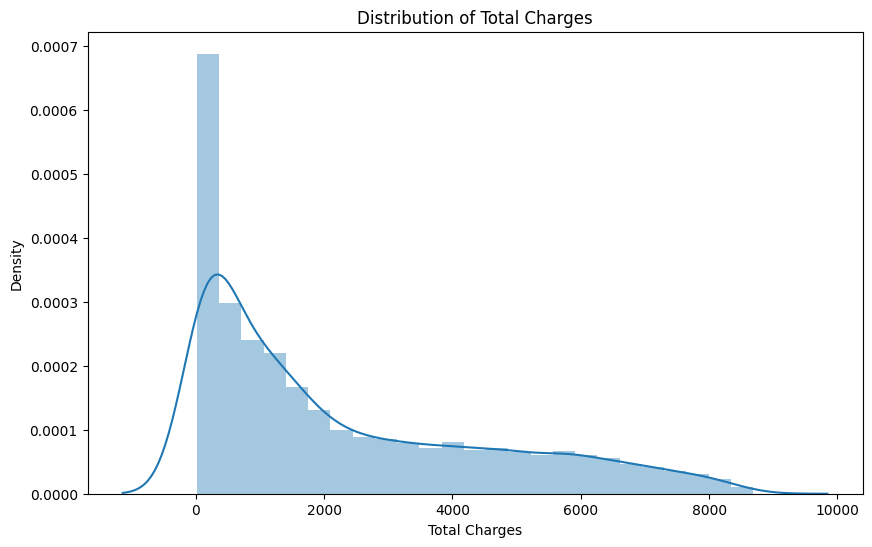

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.distplot(df['TotalCharges'])
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Density')
plt.show()

Since the distribution of totalcharge is skewed so we use median to fill the missing values

In [ ]:
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

<ipython-input-10-64493bf53d4b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


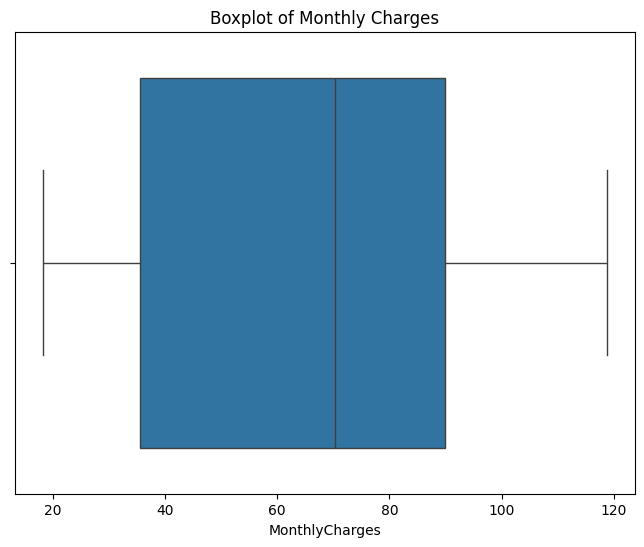

Number of rows before removing outliers: 7043
Number of rows after removing outliers: 7043


In [ ]:
#identify outliers in monthly charges column using boxplot and remove them
import matplotlib.pyplot as plt
import seaborn as sns
# Identify outliers in 'MonthlyCharges' using boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['MonthlyCharges'])
plt.title('Boxplot of Monthly Charges')
plt.show()

# Calculate quartiles and IQR
Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
df_no_outliers = df[(df['MonthlyCharges'] >= lower_bound) & (df['MonthlyCharges'] <= upper_bound)]

# Print the number of rows before and after removing outliers
print(f"Number of rows before removing outliers: {len(df)}")
print(f"Number of rows after removing outliers: {len(df_no_outliers)}")

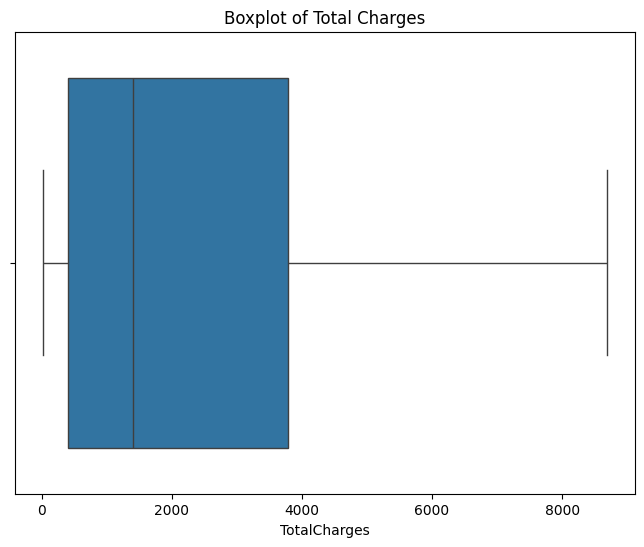

Number of rows before removing outliers: 7043
Number of rows after removing outliers: 7043


In [ ]:
# Identify outliers in 'TotalCharges' using boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['TotalCharges'])
plt.title('Boxplot of Total Charges')
plt.show()

# Calculate quartiles and IQR
Q1 = df['TotalCharges'].quantile(0.25)
Q3 = df['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
df_no_outliers = df[(df['TotalCharges'] >= lower_bound) & (df['TotalCharges'] <= upper_bound)]

# Print the number of rows before and after removing outliers
print(f"Number of rows before removing outliers: {len(df)}")
print(f"Number of rows after removing outliers: {len(df_no_outliers)}")

In [ ]:
categorical_cols = ['Dependents', 'Partner', 'SeniorCitizen', 'gender',
                    'StreamingMovies', 'StreamingTV', 'TechSupport','DeviceProtection',
                    'OnlineBackup', 'OnlineSecurity', 'InternetService', 'MultipleLines', 'Churn',
                    'PhoneService', 'Contract', 'PaperlessBilling', 'PaymentMethod']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7043 non-null   int64  
 1   MonthlyCharges                         7043 non-null   float64
 2   TotalCharges                           7043 non-null   float64
 3   Dependents_Yes                         7043 non-null   int64  
 4   Partner_Yes                            7043 non-null   int64  
 5   SeniorCitizen_1                        7043 non-null   int64  
 6   gender_Male                            7043 non-null   int64  
 7   StreamingMovies_No internet service    7043 non-null   int64  
 8   StreamingMovies_Yes                    7043 non-null   int64  
 9   StreamingTV_No internet service        7043 non-null   int64  
 10  StreamingTV_Yes                        7043 non-null   int64  
 11  Tech

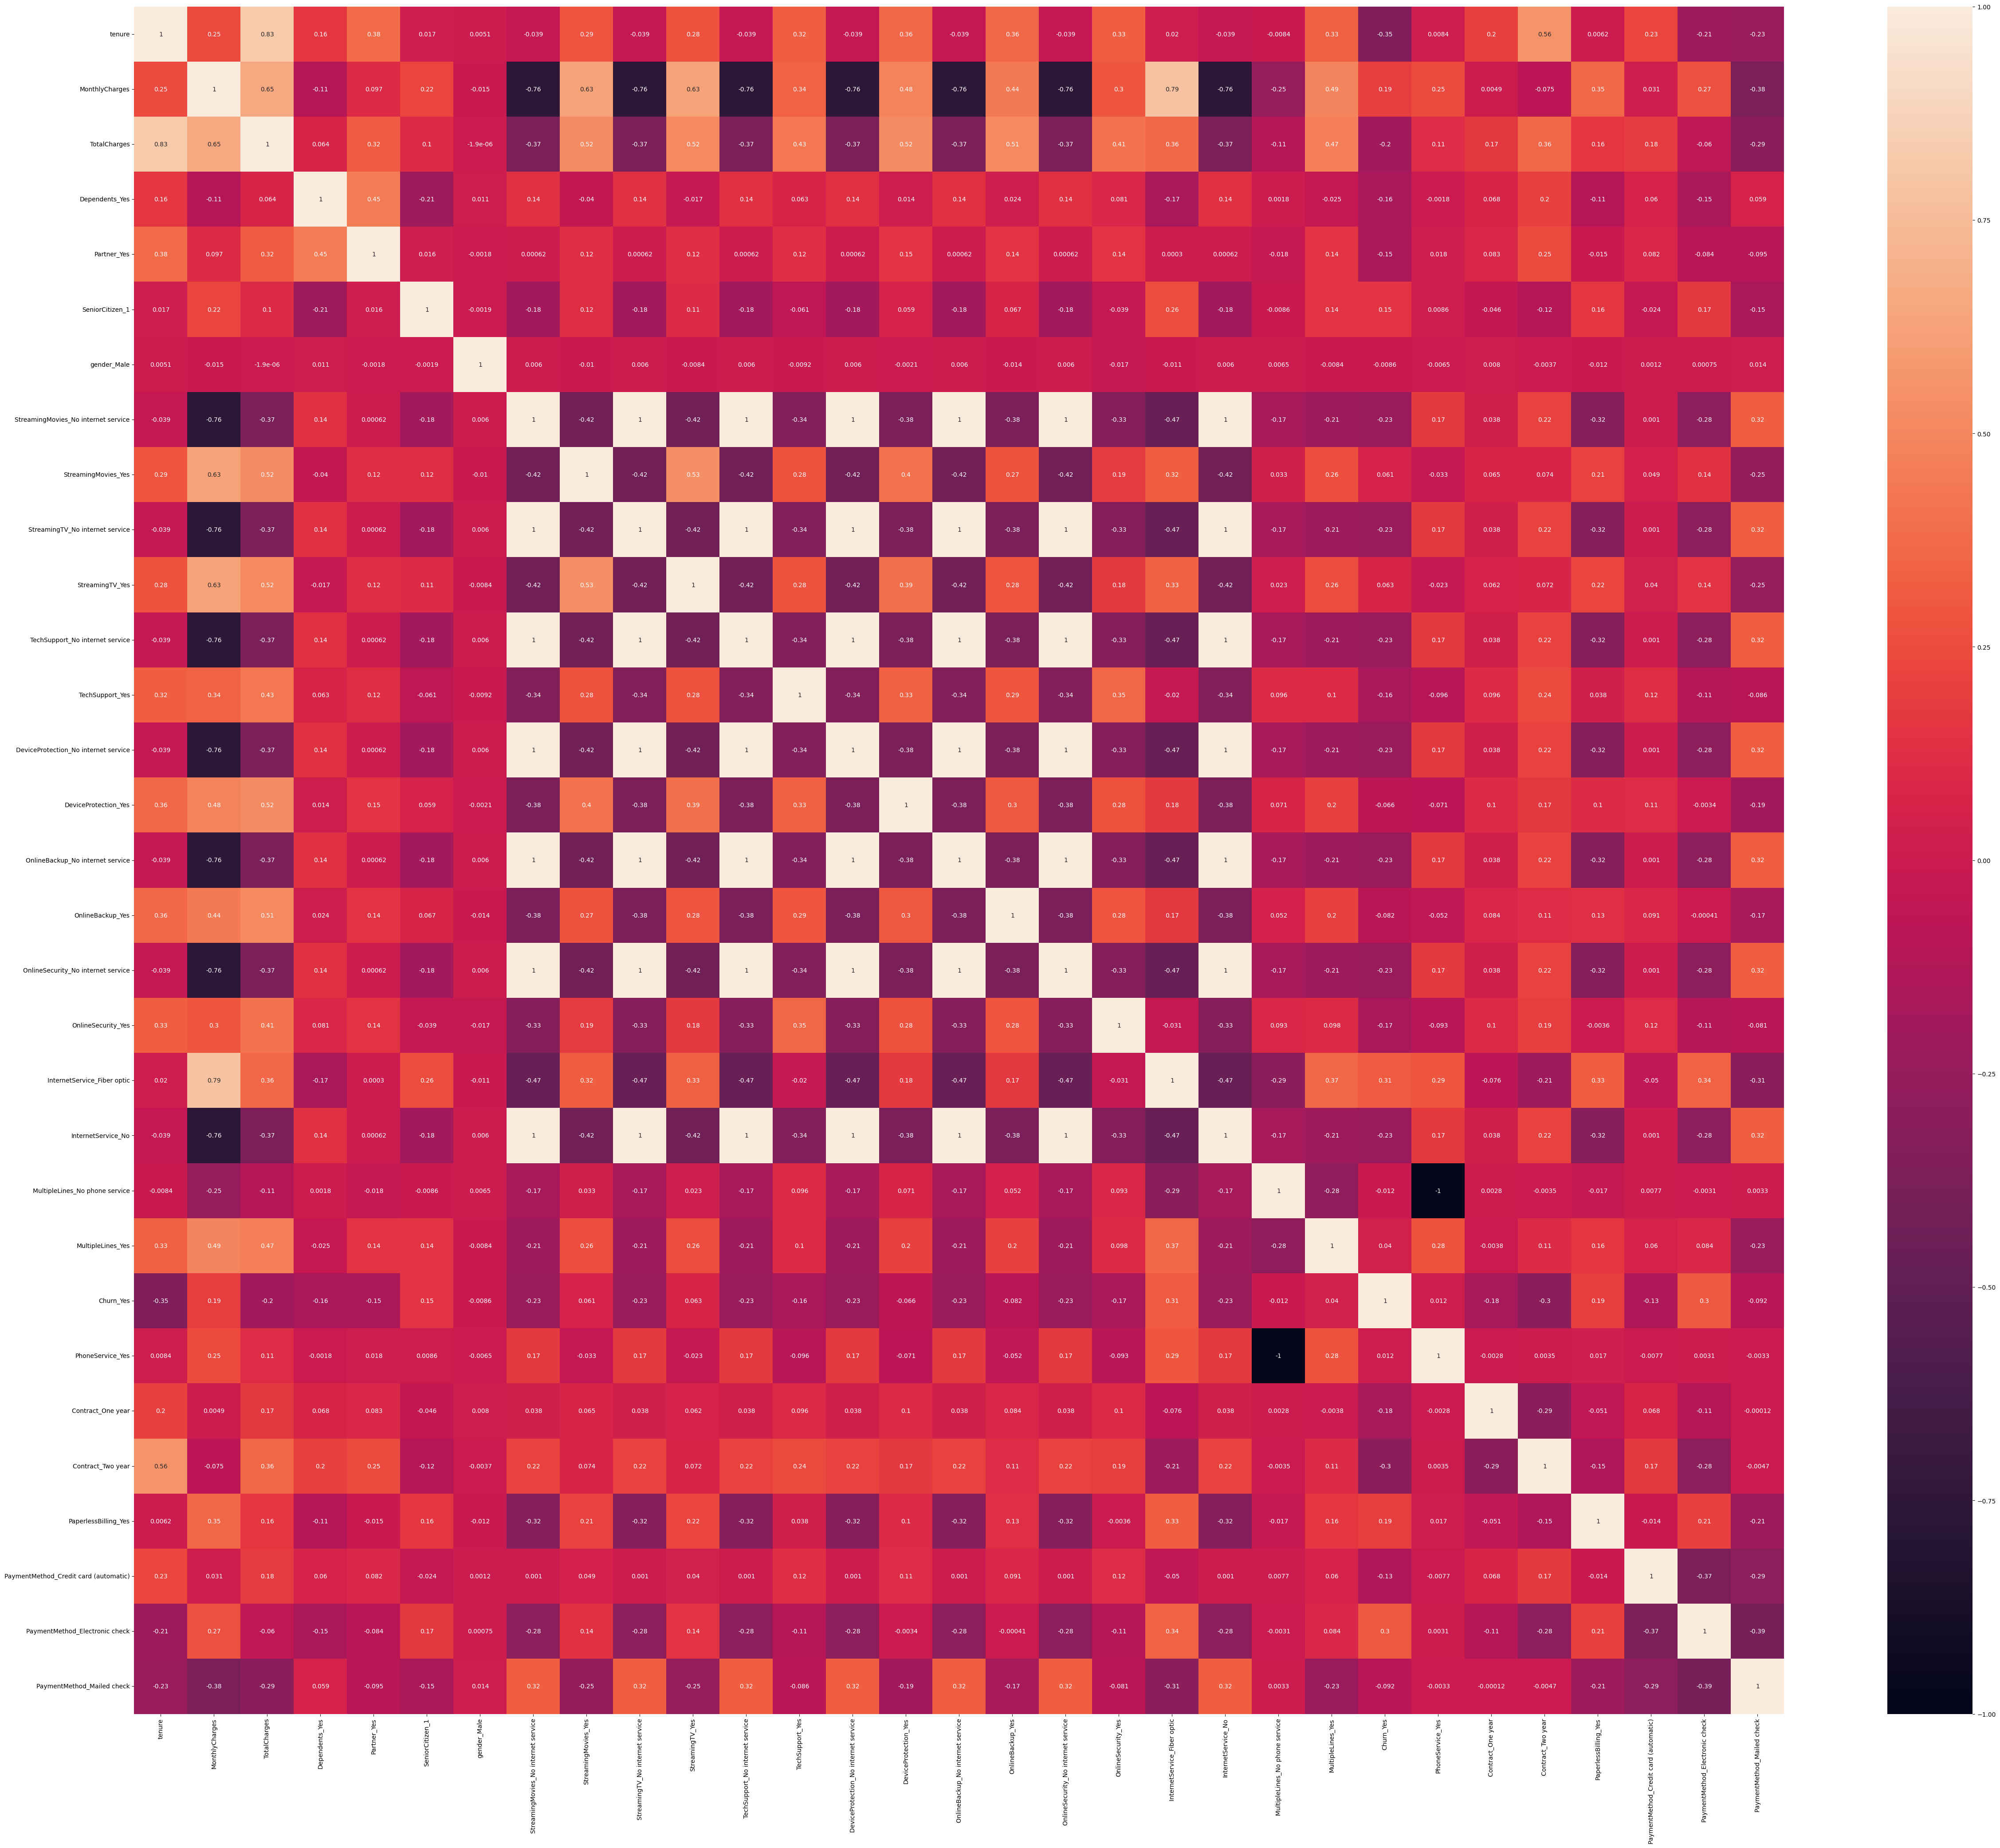

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize = (60,50))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
plt.show()

In [ ]:
import pandas as pd

# Assuming the preprocessed DataFrame is stored in the variable 'df'
# from the previous code execution

# Convert the DataFrame to a CSV file
df.to_csv('preprocessed_data.csv', index=False)  # index=False prevents writing row indices

# The CSV file will be saved in the current working directory of your Colab notebook.
# You can then download it using the file browser in the Colab interface.


TEST TRAIN SPLIT

In [ ]:
# Split dataset into training and testing sets
X = df.drop(columns=['Churn_Yes'])
y = df['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
from sklearn.preprocessing import StandardScaler
# Standardize numerical features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [ ]:
#FIND CHURN RATE

# Calculate the churn rate
churn_rate = df['Churn_Yes'].value_counts(normalize=True) * 100
churn_rate

,proportion
Churn_Yes,
0,73.463013
1,26.536987


# **Model Building**

In [ ]:
import statsmodels.api as sm
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Churn_Yes   No. Observations:                 4930
Model:                            GLM   Df Residuals:                     4906
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2035.9
Date:                Fri, 07 Mar 2025   Deviance:                       4071.7
Time:                        04:38:39   Pearson chi2:                 5.61e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2819
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.3217      0.759     -3.060      0.002      -3.809      -0.835
tenure                                   -1.3770      0.181     -7.623      0.000      -1.731      -1.023
MonthlyCharges                           -2.0845      1.134     -1.837      0.066      -4.308       0.139
TotalCharges                              0.6990      0.190      3.672      0.000       0.326       1.072
Dependents_Yes                           -0.2651      0.108     -2.463      0.014      -0.476      -0.054
Partner_Yes                              -0.0063      0.093     -0.068      0.946      -0.188       0.176
SeniorCitizen_1                           0.0522      0.037      1.400      0.162      -0.021       0.125
gender_Male                               0.0294      0.078      0.378      0.705      -0.123       0.182
StreamingMovies_No internet service      -0.3791      0.136     -2.783      0.005      -0.646      -0.112
StreamingMovies_Yes                       0.9391      0.388      2.422      0.015       0.179       1.699
StreamingTV_No internet service          -0.3791      0.136     -2.783      0.005      -0.646      -0.112
StreamingTV_Yes                           0.8413      0.386      2.181      0.029       0.085       1.597
TechSupport_No internet service          -0.3791      0.136     -2.783      0.005      -0.646      -0.112
TechSupport_Yes                          -0.0327      0.215     -0.152      0.879      -0.453       0.388
DeviceProtection_No internet service     -0.3791      0.136     -2.783      0.005      -0.646      -0.112
DeviceProtection_Yes                      0.2760      0.209      1.321      0.187      -0.134       0.686
OnlineBackup_No internet service         -0.3791      0.136     -2.783      0.005      -0.646      -0.112
OnlineBackup_Yes                          0.1444      0.206      0.700      0.484      -0.260       0.549
OnlineSecurity_No internet service       -0.3791      0.136     -2.783      0.005      -0.646      -0.112
OnlineSecurity_Yes                       -0.0895      0.212     -0.422      0.673      -0.506       0.327
InternetService_Fiber optic               2.3952      0.946      2.532      0.011       0.541       4.250
InternetService_No                       -0.3791      0.136     -2.783      0.005      -0.646      -0.112
MultipleLines_No phone service           -1.6121      0.757     -2.129      0.033      -3.096      -0.128
MultipleLines_Yes                         0.6234      0.210      2.973      0.003       0.212       1.034
PhoneService_Yes                         -0.7096      0.090     -7.915      0.000      -0.885      -0.534
Contract_One year                        -0.7311      0.130     -5.635      0.000      -0.985      -0.477
Contract_

# Feature Selection Using RFE

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=logreg, n_features_to_select=20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train, y_train)

In [ ]:
rfe.support_

array([ True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
       False,  True, False])

In [ ]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('tenure', True, 1),
 ('MonthlyCharges', True, 1),
 ('TotalCharges', True, 1),
 ('Dependents_Yes', True, 1),
 ('Partner_Yes', False, 11),
 ('SeniorCitizen_1', False, 7),
 ('gender_Male', False, 9),
 ('StreamingMovies_No internet service', True, 1),
 ('StreamingMovies_Yes', True, 1),
 ('StreamingTV_No internet service', True, 1),
 ('StreamingTV_Yes', True, 1),
 ('TechSupport_No internet service', True, 1),
 ('TechSupport_Yes', True, 1),
 ('DeviceProtection_No internet service', True, 1),
 ('DeviceProtection_Yes', False, 10),
 ('OnlineBackup_No internet service', True, 1),
 ('OnlineBackup_Yes', False, 5),
 ('OnlineSecurity_No internet service', True, 1),
 ('OnlineSecurity_Yes', True, 1),
 ('InternetService_Fiber optic', True, 1),
 ('InternetService_No', False, 2),
 ('MultipleLines_No phone service', False, 4),
 ('MultipleLines_Yes', True, 1),
 ('PhoneService_Yes', False, 3),
 ('Contract_One year', True, 1),
 ('Contract_Two year', True, 1),
 ('PaperlessBilling_Yes', True, 1),
 ('PaymentM

In [ ]:
col = X_train.columns[rfe.support_]

In [ ]:
X_train.columns[~rfe.support_]

Index(['Partner_Yes', 'SeniorCitizen_1', 'gender_Male', 'DeviceProtection_Yes',
       'OnlineBackup_Yes', 'InternetService_No',
       'MultipleLines_No phone service', 'PhoneService_Yes',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check'],
      dtype='object')

In [ ]:
#ASSESSING MODEL WITH STATSMODEL
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Churn_Yes   No. Observations:                 4930
Model:                            GLM   Df Residuals:                     4914
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2038.5
Date:                Fri, 07 Mar 2025   Deviance:                       4077.0
Time:                        04:38:40   Pearson chi2:                 5.64e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2812
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.1662      0.205    -10.556      0.000      -2.568      -1.764
tenure                                  -1.3958      0.177     -7.864      0.000      -1.744      -1.048
MonthlyCharges                          -0.8028      0.208     -3.863      0.000      -1.210      -0.395
TotalCharges                             0.7129      0.188      3.784      0.000       0.344       1.082
Dependents_Yes                          -0.2885      0.097     -2.982      0.003      -0.478      -0.099
StreamingMovies_No internet service     -0.2596      0.036     -7.293      0.000      -0.329      -0.190
StreamingMovies_Yes                      0.5187      0.116      4.486      0.000       0.292       0.745
StreamingTV_No internet service         -0.2596      0.036     -7.293      0.000      -0.329      -0.190
StreamingTV_Yes                          0.4233      0.116      3.643      0.000       0.196       0.651
TechSupport_No internet service         -0.2596      0.036     -7.293      0.000      -0.329      -0.190
TechSupport_Yes                         -0.2521      0.108     -2.332      0.020      -0.464      -0.040
DeviceProtection_No internet service    -0.2596      0.036     -7.293      0.000      -0.329      -0.190
OnlineBackup_No internet service        -0.2596      0.036     -7.293      0.000      -0.329      -0.190
OnlineSecurity_No internet service      -0.2596      0.036     -7.293      0.000      -0.329      -0.190
OnlineSecurity_Yes                      -0.3045      0.106     -2.869      0.004      -0.512      -0.096
InternetService_Fiber optic              1.3530      0.229      5.897      0.000       0.903       1.803
MultipleLines_Yes                        0.4174      0.104      3.997      0.000       0.213       0.622
Contract_One year                       -0.7397      0.129     -5.725      0.000      -0.993      -0.486
Contract_Two year                       -1.3629      0.205     -6.659      0.000      -1.764      -0.962
PaperlessBilling_Yes                     0.4086      0.089      4.574      0.000       0.234       0.584
PaymentMethod_Electronic check           0.3620      0.083      4.362      0.000       0.199       0.525
========================================================================================================
"""

In [ ]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

,0
5557,0.628491
2270,0.694293
6930,0.681737
2257,0.048316
898,0.467753
3828,0.002413
2147,0.126684
3149,0.259011
5401,0.012868
2062,0.004987


In [ ]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred = y_train_pred * 100
y_train_pred[:10]

array([62.84906933, 69.42934488, 68.17374494,  4.83157166, 46.7752685 ,
        0.24129142, 12.66838131, 25.90107764,  1.28676725,  0.49869606])

[[1391  161]
 [ 249  312]]


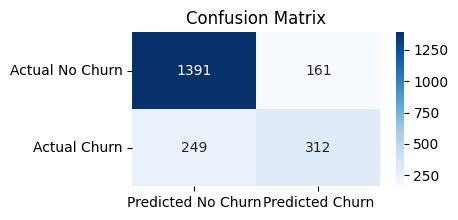

In [ ]:
# Predict on the test set
X_test_sm = sm.add_constant(X_test[col])
y_test_pred = res.predict(X_test_sm)

# Convert probabilities to class labels (0 or 1)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print or visualize the confusion matrix
print(conf_matrix)

# You can also visualize it using seaborn's heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_test_pred.round())
precision = precision_score(y_test, y_test_pred.round())
recall = recall_score(y_test, y_test_pred.round())
f1 = f1_score(y_test, y_test_pred.round())

# Print evaluation results
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')

Accuracy: 80.60%
Precision: 65.96%
Recall: 55.61%
F1-Score: 60.35%


# Checking VIFs

In [ ]:
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
10,DeviceProtection_No internet service,inf
8,TechSupport_No internet service,inf
12,OnlineSecurity_No internet service,inf
4,StreamingMovies_No internet service,inf
11,OnlineBackup_No internet service,inf
6,StreamingTV_No internet service,inf
1,MonthlyCharges,14.01
2,TotalCharges,10.40
0,tenure,6.95
14,InternetService_Fiber optic,5.78


In [ ]:
# Assuming 'col' contains the columns selected by RFE
# Get a list of columns to drop
cols_to_drop = ['OnlineBackup_No internet service',
              'DeviceProtection_No internet service',
              'TechSupport_No internet service',
              'InternetService_No',
              'StreamingMovies_No internet service',
              'StreamingTV_No internet service']

# Only drop columns that are actually in 'col'
col = col.drop([c for c in cols_to_drop if c in col], errors='ignore')

In [ ]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Churn_Yes   No. Observations:                 4930
Model:                            GLM   Df Residuals:                     4914
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2038.5
Date:                Fri, 07 Mar 2025   Deviance:                       4077.0
Time:                        04:38:41   Pearson chi2:                 5.64e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2812
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

[[1391  161]
 [ 249  312]]


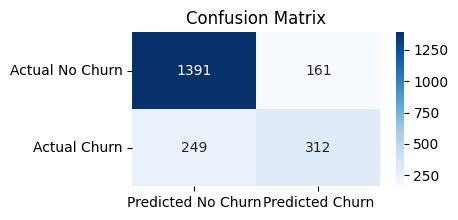

In [ ]:
# Predict on the test set
X_test_sm = sm.add_constant(X_test[col])
y_test_pred = res.predict(X_test_sm)

# Convert probabilities to class labels (0 or 1)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print or visualize the confusion matrix
print(conf_matrix)

# You can also visualize it using seaborn's heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_test_pred.round())
precision = precision_score(y_test, y_test_pred.round())
recall = recall_score(y_test, y_test_pred.round())
f1 = f1_score(y_test, y_test_pred.round())

# Print evaluation results
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')

Accuracy: 80.60%
Precision: 65.96%
Recall: 55.61%
F1-Score: 60.35%


In [ ]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,MonthlyCharges,14.01
2,TotalCharges,10.40
0,tenure,6.95
9,InternetService_Fiber optic,5.78
7,OnlineSecurity_No internet service,5.45
12,Contract_Two year,3.28
5,StreamingTV_Yes,3.01
4,StreamingMovies_Yes,2.90
13,PaperlessBilling_Yes,2.81
10,MultipleLines_Yes,2.40


In [ ]:
col = col.drop('TotalCharges',1)

In [ ]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Churn_Yes   No. Observations:                 4930
Model:                            GLM   Df Residuals:                     4915
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2046.0
Date:                Fri, 07 Mar 2025   Deviance:                       4092.0
Time:                        04:38:42   Pearson chi2:                 4.99e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2790
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

[[1383  169]
 [ 251  310]]


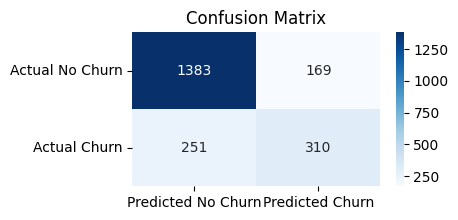

In [ ]:
# Predict on the test set
X_test_sm = sm.add_constant(X_test[col])
y_test_pred = res.predict(X_test_sm)

# Convert probabilities to class labels (0 or 1)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print or visualize the confusion matrix
print(conf_matrix)

# You can also visualize it using seaborn's heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_test_pred.round())
precision = precision_score(y_test, y_test_pred.round())
recall = recall_score(y_test, y_test_pred.round())
f1 = f1_score(y_test, y_test_pred.round())

# Print evaluation results
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')

Accuracy: 80.12%
Precision: 64.72%
Recall: 55.26%
F1-Score: 59.62%


In [ ]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,MonthlyCharges,10.61
8,InternetService_Fiber optic,5.71
6,OnlineSecurity_No internet service,5.34
11,Contract_Two year,3.26
4,StreamingTV_Yes,3.01
3,StreamingMovies_Yes,2.90
12,PaperlessBilling_Yes,2.81
9,MultipleLines_Yes,2.40
0,tenure,2.22
5,TechSupport_Yes,1.96


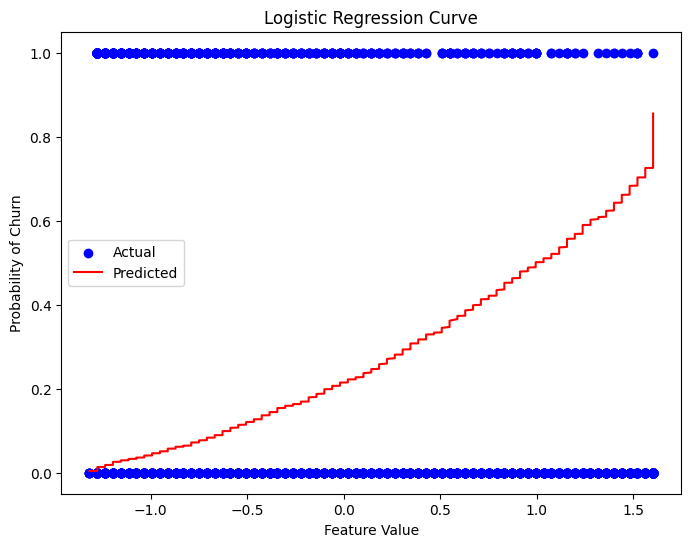

In [ ]:
# Assuming 'res' is the fitted statsmodels GLM model and 'X_test_sm' is the test data
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on the test set
y_test_pred_prob = res.predict(X_test_sm)

# Generate a logistic regression curve
plt.figure(figsize=(8, 6))
plt.scatter(X_test_sm.iloc[:, 1], y_test, color='blue', label='Actual') # Replace .iloc[:, 1] with the index of your desired feature
plt.plot(X_test_sm.iloc[:, 1].sort_values(), y_test_pred_prob.sort_values(), color='red', label='Predicted')  # Plot the logistic curve
plt.xlabel('Feature Value')  # Replace with your feature's name
plt.ylabel('Probability of Churn')
plt.title('Logistic Regression Curve')
plt.legend()
plt.show()
